# Annotated Project Part 4 - BERT

BERT for binary or multiclass document classification using the [CLS] token as the document representation; trains a model (on `train.txt`), uses `dev.txt` for early stopping, and evaluates performance on `test.txt`.  Reports test accuracy with 95% confidence intervals.

Before executing this notebook on Colab, make sure you're running on cuda (`Runtime > Change runtime type > GPU`) to make use of GPU speedups.

## 1. Setup

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.0 MB/s eta 0:00:00


In [2]:
from transformers import BertModel, BertTokenizer,RobertaModel,RobertaTokenizer
from transformers import AutoModel, AutoTokenizer 
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## 2. Loading the Data

In [3]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

# Change this to the directory with your data
# Togel between the two by commenting

# directory="/content/drive/MyDrive/INFO 159" # Jackson
directory="/content/drive/MyDrive/Spring 2023/info159/Info 159 Annotated Project/AP4" # Johnson

# Make sure we are running on CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Mounted at /content/drive
Running on cuda


In [4]:
def make_label_map(filename):
    """
    Map labels in the data files (strings) to
    integer labels for the model
    """
    labels = {}

    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            if label not in labels:
                labels[label] = len(labels) # New integer label based on map's length

    return labels

def read_data(filename, labels, max_data_points=1000):
    """
    Read the data and the label. 
    Replace <<NEWL>> with \n and <<TAB>> with \t
    """
    data = []
    data_labels = []
    
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[2]
            text : str = cols[3]
            
            text = text.replace("<<NEWL>>", "\n")
            text = text.replace("<<TAB>>", "\t")

            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [5]:
labels=make_label_map("%s/train.txt" % directory)
train_x, train_y=read_data("%s/train.txt" % directory, labels, max_data_points=None)
dev_x, dev_y=read_data("%s/dev.txt" % directory, labels,max_data_points=None)
test_x, test_y=read_data("%s/test.txt" % directory, labels,max_data_points=None)
print("Training data length:", len(train_x), len(train_y))
print("Development data length:", len(dev_x), len(dev_y))
print("Testing data length:", len(test_x), len(test_y))

Training data length: 300 300
Development data length: 100 100
Testing data length: 100 100


In [6]:
# Let's see what our data looks like
print("Data:\n", train_x[0][:100], "... (only showing first 100 characters)") # First 100 characters of our data
print("==============")
print("Label: ", train_y[0])

Data:
 "# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the ""License"");
# ... (only showing first 100 characters)
Label:  4


## 3. Finetune BERT

In [7]:
def evaluate(model, x, y):
    """
    Return the accuracy and the predictions
    """
    model.eval()
    corr = 0. # Counter for correct prediction
    total = 0. # Total counter
    y_preds = []
    with torch.no_grad():
        for x, y in zip(x, y):
            outputs = model.forward(x)
            for idx, output in enumerate(outputs):
                y_pred=torch.argmax(output)
                y_preds.append(y_pred)
                if y_pred == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, y_preds # accuracy, total number

In [8]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
    
        self.model_name=bert_model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = AutoModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]
        self.fc1 = nn.Linear(params["embedding_size"], params["embedding_size"])

        self.fc2 = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=16, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        if "token_type_ids" in batch_x:
            bert_output = self.bert(
                input_ids=batch_x["input_ids"],
                attention_mask=batch_x["attention_mask"],
                token_type_ids=batch_x["token_type_ids"],
                output_hidden_states=True
            )
        else:
            bert_output = self.bert(
                input_ids=batch_x["input_ids"],
                attention_mask=batch_x["attention_mask"],
                output_hidden_states=True
            )
      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc1(out)

        out = self.fc2(out)

        return out.squeeze()

In [9]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.AdamW(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()
    step_size = 4  # The number of epochs between learning rate reductions
    gamma = 0.6     # The factor by which to reduce the learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    num_epochs = 40 # default is 40
    best_dev_acc = 0
    patience = 10

    best_epoch = 0
    pretrain_epochs = 10 # default is 10

    # === PRETRAIN ===
    # We freeze the main BERT model at first and only
    # finetune the very last layer

    print("==== PRETRAINING PHASE ====")

    for param in bert_model.bert.parameters():
        param.requires_grad = False

    pretrain_accuracies = [] # Record the pretrain dev accuracies of each epoch for plotting

    # Pretrain phase (only the last layer)
    for epoch in range(pretrain_epochs):
        bert_model.train()
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _ = evaluate(bert_model, dev_batch_x, dev_batch_y)
        pretrain_accuracies.append(dev_accuracy) # Record accuracy

        print("PRETRAINING Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))

    # === FINETUNE ===
    # Unfreeze the main BERT model and 
    # optimize all parameters

    print("==== FINETINUING PHASE ====")

    for param in bert_model.parameters():
        param.requires_grad = True
    
    finetune_accuracies = [] # Record the finetune dev accuracies of each epoch for plotting

    # General fine-tune phase
    for epoch in range(num_epochs):
        bert_model.train()
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

        # Evaluate
        dev_accuracy, _ = evaluate(bert_model, dev_batch_x, dev_batch_y)
        finetune_accuracies.append(dev_accuracy) # Record accuracy

        print("FINETINUING Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))

        if dev_accuracy > best_dev_acc:
            torch.save(bert_model.state_dict(), model_filename)
            best_dev_acc = dev_accuracy
            best_epoch=epoch

        # Early stopping based on patience
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model, pretrain_accuracies, finetune_accuracies


In [10]:
# small BERT -- can run on laptop
# ===============================
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True


# bert-base -- slow on laptop; better on Colab
# microsoft/codebert-base
# neulab/codebert-python
# ============================================
bert_model_name="neulab/codebert-python"
model_filename="mybert.model"
embedding_size=768
doLowerCase=False

model, pretrain_accuracies, finetune_accuracies = train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Some weights of the model checkpoint at neulab/codebert-python were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


==== PRETRAINING PHASE ====
PRETRAINING Epoch 0, dev accuracy: 0.250
PRETRAINING Epoch 1, dev accuracy: 0.250
PRETRAINING Epoch 2, dev accuracy: 0.240
PRETRAINING Epoch 3, dev accuracy: 0.260
PRETRAINING Epoch 4, dev accuracy: 0.300
PRETRAINING Epoch 5, dev accuracy: 0.300
PRETRAINING Epoch 6, dev accuracy: 0.310
PRETRAINING Epoch 7, dev accuracy: 0.320
PRETRAINING Epoch 8, dev accuracy: 0.330
PRETRAINING Epoch 9, dev accuracy: 0.350
==== FINETINUING PHASE ====
FINETINUING Epoch 0, dev accuracy: 0.350
FINETINUING Epoch 1, dev accuracy: 0.500
FINETINUING Epoch 2, dev accuracy: 0.520
FINETINUING Epoch 3, dev accuracy: 0.530
FINETINUING Epoch 4, dev accuracy: 0.560
FINETINUING Epoch 5, dev accuracy: 0.590
FINETINUING Epoch 6, dev accuracy: 0.610
FINETINUING Epoch 7, dev accuracy: 0.590
FINETINUING Epoch 8, dev accuracy: 0.580
FINETINUING Epoch 9, dev accuracy: 0.570
FINETINUING Epoch 10, dev accuracy: 0.560
FINETINUING Epoch 11, dev accuracy: 0.560
FINETINUING Epoch 12, dev accuracy: 0.56

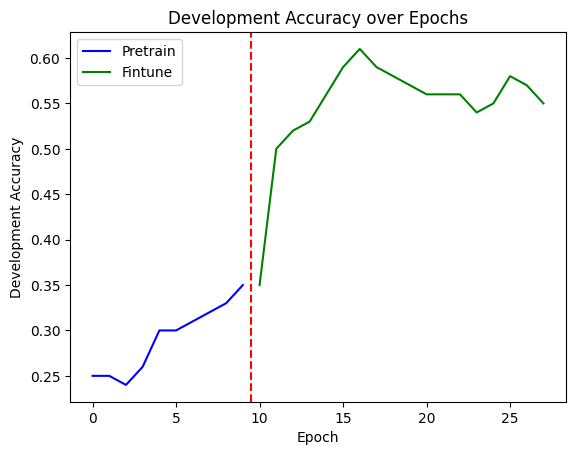

In [11]:
all_accuracies = pretrain_accuracies + finetune_accuracies
epochs = range(len(all_accuracies))

# List of colors to seperate finetune and pretrain
colors = ['b'] * len(pretrain_accuracies) + ['g'] * len(finetune_accuracies)

# Plot the accuracies for phase 1 as a blue line segment
plt.plot(epochs[:len(pretrain_accuracies)], pretrain_accuracies, 'b')

# Plot the accuracies for phase 2 as a green line segment
plt.plot(epochs[len(pretrain_accuracies):], finetune_accuracies, 'g')

# Vertical dashed red line to differentiate the phases
plt.axvline(x=len(pretrain_accuracies) - 0.5, linestyle='--', color='r')

plt.xlabel('Epoch')
plt.ylabel('Development Accuracy')
plt.title('Development Accuracy over Epochs')

# Legend to indicate the color coding
plt.legend(handles=[plt.Line2D([], [], color='b', label='Pretrain'),
                    plt.Line2D([], [], color='g', label='Fintune')])

plt.show()

## 4. Evaluation

In [12]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [13]:
# Baseline: Majority class accuracy
# =================================

from collections import Counter
def majority_class(trainY, evalY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    # print("Training data label distribution:", labelCounts)
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in evalY:
        labelCounts[label]+=1
        if label == majority_class:
            correct+=1
    return majority_class, correct/len(evalY)

mc, mc_devAcc=majority_class(train_y, dev_y)
_, mc_testAcc=majority_class(train_y, test_y)

print("Majority class (label): %s, dev accuracy: %.3f, test accuracy: %.3f" % (mc, mc_devAcc, mc_testAcc))

Majority class (label): 4, dev accuracy: 0.250, test accuracy: 0.250


In [14]:
# Test accuracy using finetuned BERT

test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, predictions=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, len(test_y), .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.480, 95% CIs: [0.382 0.578]



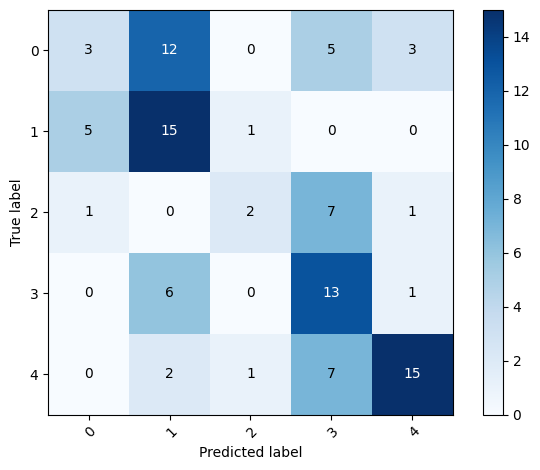

In [15]:
labels = np.unique(test_y)  # Get unique labels from y_test

predictions = np.array([tensor.cpu().numpy() for tensor in predictions]) # Transform to device = cpu

# Calculate confusion matrix
cm = confusion_matrix(test_y, predictions, labels=labels)  # Calculate confusion matrix

# Draw confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd' # format
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


## 5. Analysis

In [20]:
# Let's look at the data when true == 0 and predicted == 1

indices_of_interest = [i for i in range(len(test_y)) if test_y[i] == 0 and predictions[i] == 1]

print(test_x[indices_of_interest[0]])
print("=============================")
print(test_x[indices_of_interest[6]])

"# Copyright 2016 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the ""License"");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an ""AS IS"" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import uuid

import pytest

from product_management import create_product, delete_product
from reference_image_management import (
    create_reference_image, delete_reference_image, list_reference_images)


PROJECT_ID = os.getenv('GOOGLE_CLOUD_PROJECT')
LOCATION = 'us-west1'

PRODUCT_DISPLAY_NAME = 'fake_product_display_name_for_testing'
PRODUCT_CATEGORY = 'homegoods'
PRODUCT_ID = 'test_{}'.format(uuid.uui

In [21]:
# Let's look at the data when true == 0 and predicted == 1

indices_of_interest = [i for i in range(len(test_y)) if test_y[i] == 0 and predictions[i] == 4]

print(test_x[indices_of_interest[0]])
print("=============================")
print(test_x[indices_of_interest[1]])

"# Levels
DEBUG = 10
INFO = 20
WARNING = 30
ERROR = 40
CRITICAL = 50


class CheckMessage:

    def __init__(self, level, msg, hint=None, obj=None, id=None):
        assert isinstance(level, int), ""The first argument should be level.""
        self.level = level
        self.msg = msg
        self.hint = hint
        self.obj = obj
        self.id = id

    def __eq__(self, other):
        return (
            isinstance(other, self.__class__) and
            all(getattr(self, attr) == getattr(other, attr)
                for attr in ['level', 'msg', 'hint', 'obj', 'id'])
        )

    def __str__(self):
        from django.db import models

        if self.obj is None:
            obj = ""?""
        elif isinstance(self.obj, models.base.ModelBase):
            # We need to hardcode ModelBase and Field cases because its __str__
            # method doesn't return ""applabel.modellabel"" and cannot be changed.
            obj = self.obj._meta.label
        else:
            obj = str